In [1]:
!pip install -q seaborn

In [2]:
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split

import seaborn as sns

In [3]:
import tensorflow as tf

from tensorflow import keras
from keras import layers, models

print(tf.__version__)

2.8.2


In [4]:
# Ocitavanje kategorija
column_names_categories = ['code','parent-code','name']
categories_data = pd.read_csv('categories.csv', names = column_names_categories, na_values = '?', comment='\t', sep=',', skipinitialspace=True, header=0)
categories_data.head()

,code,parent-code,name
0,0,A,Other
1,1,B,Other
2,2,B,Auto Insurance
3,3,B,Auto Leasing
4,4,B,Gas & Fuel


In [5]:
# Ocitavanje mcc kodova
column_names_mmc = ['code', 'merchant-type']
mcc_data = pd.read_csv('mmc_codes.csv', names = column_names_mmc, na_values = '?', comment='\t', sep=',', skipinitialspace=True, header=0)
mcc_data.head()

,code,merchant-type
0,4814,Telecommunication service including local and ...
1,4815,VisaPhone
2,4821,Telegraph services
3,4829,Money Orders - Wire Transfer
4,4899,Cable and other pay television (previously Cab...


In [6]:
def preproccess_data(data_url, labels_url = None):
  column_names_data = ['id', 'beneficiary-name', 'date', 'direction', 'amount', 'description', 'currency', 'mcc', 'kind']
  if labels_url == None:
    column_names_data += ['label']

  dataset = pd.read_csv(data_url, names = column_names_data, na_values = '?', comment='\t', sep=',', skipinitialspace=True, header=0)
  dataset.head()

  #amount
  dataset['amount'] = dataset['amount'].map(lambda x : float(x.replace(",", "")))
  
  #date => day, month, year

  days = [str(i) + "d" for i in range(1, 32)]
  months = [str(i) + "m" for i in range(1, 13)]

  dataset[["month", "day", "year"]] = dataset["date"].str.split("/", expand=True)
  del dataset['date']
  del dataset['year']
  
  dataset['day'] = dataset['day'].map(lambda x : x + "d")
  dataset['month'] = dataset['month'].map(lambda x : x + "m")

  # handle days as categorical
  unique_days_columns = dataset['day'].unique()

  days_dummy = pd.get_dummies(dataset['day'], prefix='', prefix_sep='')
  dataset = pd.concat([dataset, days_dummy], axis=1, join='inner')

  missing_columns_days = set(days) - set(unique_days_columns)
  values = [[0 for i in range(len(missing_columns_days))] for i in range(dataset.shape[0])]
  missing_df_days = pd.DataFrame(values, columns=missing_columns_days)

  dataset = pd.concat([dataset, missing_df_days], axis = 1, join='inner')
  del dataset['day']

  # handle months as categorical

  unique_months_columns = dataset['month'].unique()

  months_dummy = pd.get_dummies(dataset['month'], prefix='', prefix_sep='')
  dataset = pd.concat([dataset, months_dummy], axis=1, join='inner')

  missing_columns_months = set(months) - set(unique_months_columns)
  values = [[0 for i in range(len(missing_columns_months))] for i in range(dataset.shape[0])]
  missing_df_months = pd.DataFrame(values, columns=missing_columns_months)

  dataset = pd.concat([dataset, missing_df_months], axis = 1, join='inner')
  del dataset['month']

  #kind
  kinds = ['dep', 'wdw', 'pmt', 'fee', 'inc', 'rev', 'adj', 'lnd', 'lnr', 'fcx', 'aop', 'acl', 'spl', 'sal']
  
  # check nan values
  dataset['kind'] = dataset['kind'].fillna('U')

  # unique columns of given data (can be subset of all kinds)
  unique_kinds_columns = dataset['kind'].unique()
  
  # get dummies
  kind_dummy = pd.get_dummies(dataset['kind'], prefix='', prefix_sep='')
  dataset = pd.concat([dataset, kind_dummy], axis=1, join='inner')

  # handle missing columns from kinds
  missing_columns_kinds = set(kinds) - set(unique_kinds_columns)
  missing_columns_kinds = [str(x) for x in missing_columns_kinds]
  values = [[0 for i in range(len(missing_columns_kinds))] for i in range(dataset.shape[0])]
  missing_df_kinds = pd.DataFrame(values, columns=missing_columns_kinds)

  dataset = pd.concat([dataset, missing_df_kinds], axis = 1, join='inner')

  del dataset['kind']

  #direction
  direction_dummy = pd.get_dummies(dataset['direction'], prefix='', prefix_sep='')
  del dataset['direction']
  dataset = pd.concat([dataset, direction_dummy], axis=1, join='inner')


  # mcc
  
  # fill nan values & convert to int
  dataset['mcc'] = dataset['mcc'].fillna('0')
  dataset = dataset.astype({"mcc" : int})

  unique_columns_mcc = dataset['mcc'].unique()
  
  # get dummies
  mcc_dummy = pd.get_dummies(dataset['mcc'], prefix='', prefix_sep='')
  dataset = pd.concat([dataset, mcc_dummy], axis=1, join='inner')

  # handle missing values from mcc codes
  mcc_data['code'] = mcc_data['code'].astype({"code" : int}) 
  missing_columns_mcc = set(mcc_data['code']) - set(unique_columns_mcc)
  missing_columns_mcc = [str(x) for x in missing_columns_mcc]
  values = [[0 for i in range(len(missing_columns_mcc))] for i in range(dataset.shape[0])]
  missing_df_mcc = pd.DataFrame(values, columns=missing_columns_mcc)

  dataset = pd.concat([dataset, missing_df_mcc], axis = 1, join='inner')
  del dataset['mcc']

  # description
  del dataset['description']
  
  # beneficiary name
  del dataset['beneficiary-name']
  
  # currency
  del dataset['currency']
  
  # id
  del dataset['id']

  if labels_url != None:
    column_names_labels = ['id', 'label']
    dataset_labels = pd.read_csv(labels_url, names = column_names_labels, na_values = '?', comment='\t', sep = ',' , skipinitialspace=True, header=0)
    dataset_labels.pop('id')
    # add label column
    dataset['label'] = dataset_labels
  
  return dataset

In [7]:
dataset = preproccess_data("transactions.csv", "transactions_labels.csv")
dataset.shape

(1303, 314)

In [8]:
X = dataset.drop('label', axis = 1)
y = dataset[['label']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [9]:
def build_model(dataset):
  # TODO , nije lepo numerisano
  # num_classes = 107 
  num_classes = categories_data['code'].max() + 1
  num_parameters = dataset.shape[1] - 1

  model = models.Sequential()
  model.add(layers.Dense(64, activation='relu', input_dim= num_parameters))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(128, activation='relu'))
  model.add(layers.Dropout(0.2))
  model.add(layers.Dense(256, activation='relu'))
  model.add(layers.Dense(num_classes, activation='softmax'))

  optimizer = tf.keras.optimizers.Adam()

  model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
                optimizer = optimizer,
                metrics=['accuracy'])
  return model

In [10]:
model = build_model(dataset)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                20096     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 256)               33024     
                                                                 
 dense_3 (Dense)             (None, 107)               27499     
                                                                 
Total params: 88,939
Trainable params: 88,939
Non-traina

In [11]:
# checkpoint
! mkdir models

checkpoint_filepath = '/content/models'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True
)

mkdir: cannot create directory ‘models’: File exists


In [12]:
num_classes = categories_data['code'].max() + 1
epochs = 500
batch_size = 64

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience = 25)

train_labels_cat = tf.keras.utils.to_categorical(y_train, num_classes)
test_labels_cat = tf.keras.utils.to_categorical(y_test, num_classes)


# add batch size
history = model.fit(X_train, train_labels_cat, epochs = epochs, batch_size = batch_size, validation_split = 0.2, callbacks=[early_stop, model_checkpoint_callback])
model.load_weights(checkpoint_filepath)

Epoch 1/500
13/13 [==============================] - 2s 51ms/step - loss: 7.4428 - accuracy: 0.0525 - val_loss: 4.5288 - val_accuracy: 0.0051
Epoch 2/500
13/13 [==============================] - 0s 13ms/step - loss: 5.3621 - accuracy: 0.0359 - val_loss: 4.4659 - val_accuracy: 0.0051
Epoch 3/500
13/13 [==============================] - 0s 16ms/step - loss: 4.8524 - accuracy: 0.1088 - val_loss: 4.3299 - val_accuracy: 0.3061
Epoch 4/500
13/13 [==============================] - 0s 12ms/step - loss: 4.6741 - accuracy: 0.2279 - val_loss: 4.3182 - val_accuracy: 0.3061
Epoch 5/500
13/13 [==============================] - 0s 16ms/step - loss: 4.7506 - accuracy: 0.2471 - val_loss: 4.2764 - val_accuracy: 0.2092
Epoch 6/500
13/13 [==============================] - 0s 17ms/step - loss: 4.5999 - accuracy: 0.2574 - val_loss: 4.0176 - val_accuracy: 0.3469
Epoch 7/500
13/13 [==============================] - 0s 11ms/step - loss: 4.0663 - accuracy: 0.2919 - val_loss: 3.8043 - val_accuracy: 0.3469
Epoch 

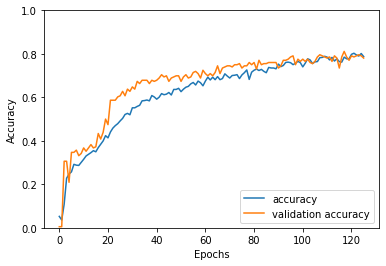

In [13]:
# Evaluation

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.ylim([0.0, 1])
plt.legend(loc='lower right')

In [14]:
test_loss, test_acc = model.evaluate(X_test, test_labels_cat, verbose=2)

11/11 - 0s - loss: 0.8167 - accuracy: 0.7607 - 96ms/epoch - 9ms/step


In [15]:
model = build_model(dataset)

early_stop_epochs = 116

mid_history = model.fit(X_train, train_labels_cat, epochs=early_stop_epochs)

Epoch 1/116
31/31 [==============================] - 1s 5ms/step - loss: 7.4908 - accuracy: 0.1157
Epoch 2/116
31/31 [==============================] - 0s 8ms/step - loss: 5.5102 - accuracy: 0.1167
Epoch 3/116
31/31 [==============================] - 0s 7ms/step - loss: 4.8254 - accuracy: 0.2477
Epoch 4/116
31/31 [==============================] - 0s 8ms/step - loss: 4.3620 - accuracy: 0.2590
Epoch 5/116
31/31 [==============================] - 0s 5ms/step - loss: 3.4516 - accuracy: 0.3122
Epoch 6/116
31/31 [==============================] - 0s 7ms/step - loss: 3.2115 - accuracy: 0.3173
Epoch 7/116
31/31 [==============================] - 0s 7ms/step - loss: 2.9847 - accuracy: 0.3388
Epoch 8/116
31/31 [==============================] - 0s 9ms/step - loss: 2.6667 - accuracy: 0.3408
Epoch 9/116
31/31 [==============================] - 0s 8ms/step - loss: 2.6700 - accuracy: 0.3623
Epoch 10/116
31/31 [==============================] - 0s 6ms/step - loss: 2.5134 - accuracy: 0.3961
Epoch 11/

In [16]:
test_loss, test_acc = model.evaluate(X_test, test_labels_cat, verbose=2)

11/11 - 0s - loss: 0.8600 - accuracy: 0.7607 - 167ms/epoch - 15ms/step


In [17]:
model = build_model(dataset)

early_stop_epochs = 116

y_cat = tf.keras.utils.to_categorical(y, num_classes)


final_history = model.fit(X, y_cat, epochs=early_stop_epochs)

Epoch 1/116
41/41 [==============================] - 1s 3ms/step - loss: 5.9453 - accuracy: 0.1013
Epoch 2/116
41/41 [==============================] - 0s 4ms/step - loss: 4.6876 - accuracy: 0.2502
Epoch 3/116
41/41 [==============================] - 0s 3ms/step - loss: 4.1069 - accuracy: 0.2878
Epoch 4/116
41/41 [==============================] - 0s 4ms/step - loss: 3.3169 - accuracy: 0.3047
Epoch 5/116
41/41 [==============================] - 0s 3ms/step - loss: 2.9611 - accuracy: 0.3208
Epoch 6/116
41/41 [==============================] - 0s 4ms/step - loss: 2.5029 - accuracy: 0.3484
Epoch 7/116
41/41 [==============================] - 0s 4ms/step - loss: 2.3580 - accuracy: 0.3876
Epoch 8/116
41/41 [==============================] - 0s 4ms/step - loss: 2.1725 - accuracy: 0.4351
Epoch 9/116
41/41 [==============================] - 0s 4ms/step - loss: 1.9772 - accuracy: 0.4705
Epoch 10/116
41/41 [==============================] - 0s 4ms/step - loss: 1.9137 - accuracy: 0.5119
Epoch 11/

In [18]:
model_path = 'models/categories_network.h5'
model.save(model_path)

! ls models

categories_network.h5


In [19]:
model = None
model = tf.keras.models.load_model(model_path)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_8 (Dense)             (None, 64)                20096     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_9 (Dense)             (None, 128)               8320      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 256)               33024     
                                                                 
 dense_11 (Dense)            (None, 107)               27499     
                                                                 
Total params: 88,939
Trainable params: 88,939
Non-trai

In [21]:
test_loss, test_acc = model.evaluate(X, y_cat, verbose=2)

41/41 - 0s - loss: 0.2394 - accuracy: 0.9256 - 162ms/epoch - 4ms/step
